In [2]:
import numpy as np
import random
import operator
import pandas as pd
import matplotlib.pyplot as plt
import itertools 


## Create necessary classes and functions

Create class to handle "cities"

In [3]:
class cities:
    def __init__(self, ncities):
        self.ncities = ncities
        self.cities = np.random.randint(0, 100, (ncities+1, 2))
        self.cities[-1, :] = self.cities[0, :]

    def copy(self):
        ct = cities(self.ncities)
        ct.cities = self.cities.copy()
        return ct

class route:
    def __init__(self, ct, rt=None):
        self.cities = ct.copy()
        self.route = rt
        if self.route == None:
            self.route = np.random.permutation(ct.ncities-1)+1

    def copy(self):
        rt = route(self.cities)
        rt.route = self.route.copy()
        return rt

    def get_ordered_cities(self):
        idx = np.arange(0, self.cities.ncities+1, 1, dtype=int)
        idx[1:-1] = self.route
        return self.cities.cities[idx, :]

    def cost(self):
        dx = np.square(np.diff(self.get_ordered_cities()[:, 0]))
        dy = np.square(np.diff(self.get_ordered_cities()[:, 1]))
        return np.sum(np.sqrt(dx + dy))

    def show(self):
        plt.figure(figsize=(15, 12))
        plt.plot(self.get_ordered_cities()[:, 0], self.get_ordered_cities()[:, 1], marker = '.', markersize = 10)
        plt.title(f'Route cost = {self.cost()}')
        plt.show()

    def __str__(self):
        return str(self.route)

    def iterate_neighbors(self, num=2):
        for comb in itertools.combinations(range(self.cities.ncities-1), 2):
            new_route = self.copy()
            new_route.route[comb[0]] = self.route[comb[1]]
            new_route.route[comb[1]] = self.route[comb[0]]
            yield new_route

    def mutate(self, mutation_rate):
        for idx2 in range(self.cities.ncities-1):
            if(random.random() < mutation_rate):
                idx2 = int(random.random() * len(self.cities.ncities-1))
                
                c1 = self.route[idx1+1]
                self.route[idx1+1] = self.route[idx2+1]
                self.route[idx2+1] = c1


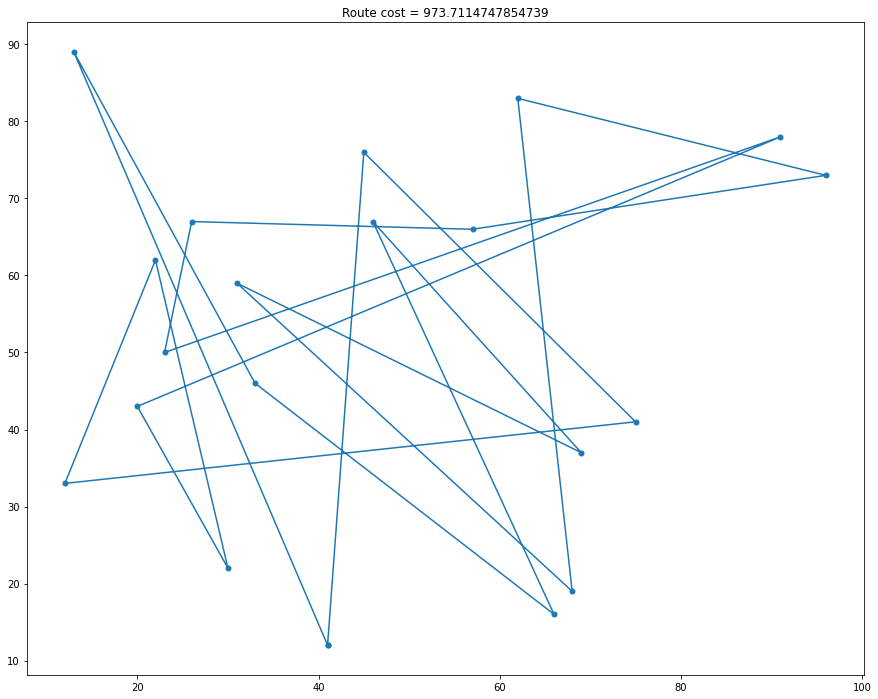

In [4]:
ct = cities(20)
rt = route(ct)
rt.show()

In [5]:
def hill_climbing(rstart, niter=10):
    current_route = rstart.copy()
    history = np.zeros((niter,))
    for idx, iter in enumerate(range(niter)):
        history[idx] = current_route.cost()
        for iter in current_route.iterate_neighbors(2):
            if iter.cost() < current_route.cost():
                current_route = iter.copy()
    return current_route, history


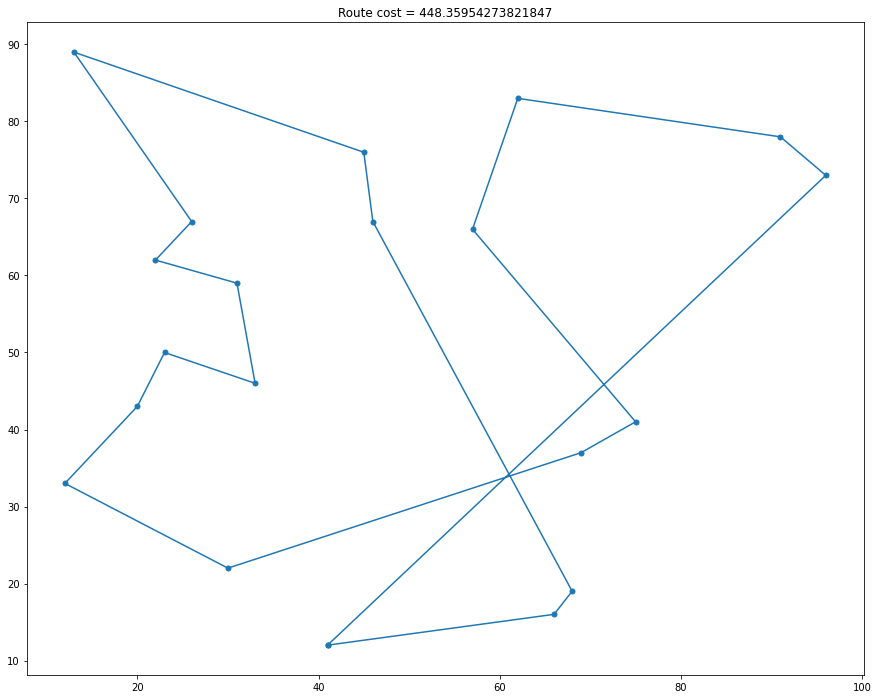

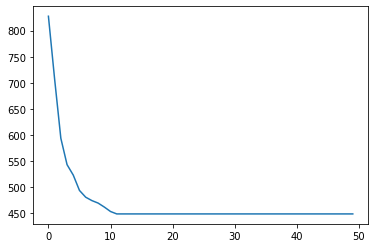

In [14]:
new_route, history = hill_climbing(rt, niter=50)
new_route.show()
plt.plot(history)
plt.show()

In [7]:
def hill_climbing_restart(cities, nstarts=10, niter=10):
    best_rt = route(cities)
    history_all = np.zeros((nstarts, niter))
    for idx, s in enumerate(range(nstarts)):
        new_rt, history = hill_climbing(route(cities), niter)
        history_all[idx, :] = history
        if new_rt.cost() < best_rt.cost():
            best_rt = new_rt
    return best_rt, history_all


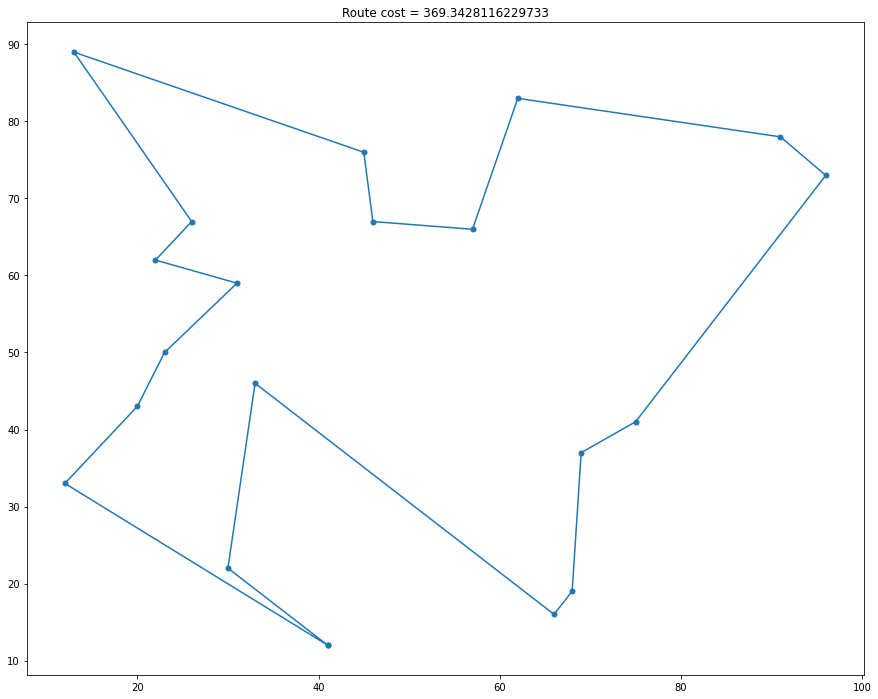

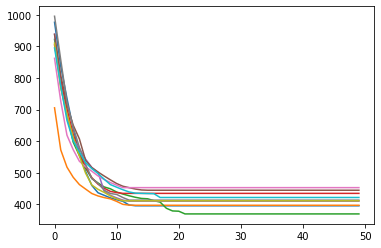

In [8]:
new_route, history_all = hill_climbing_restart(ct, nstarts=10, niter=50)
new_route.show()
plt.plot(history_all.T)
plt.show()

In [9]:
def simulated_anealing(rstart, niter=10, temp=100.0):
    current_route = rstart.copy()
    history = np.zeros((niter,))
    for i in range(niter):
        history[i] = current_route.cost()
        for iter in current_route.iterate_neighbors(3):
            diff = current_route.cost() - iter.cost()
            t = temp / (i+1)
            metropolis = np.exp(-np.abs(diff)/t)
            if diff > 0 or np.random.rand() < metropolis:
                current_route = iter
    return current_route, history


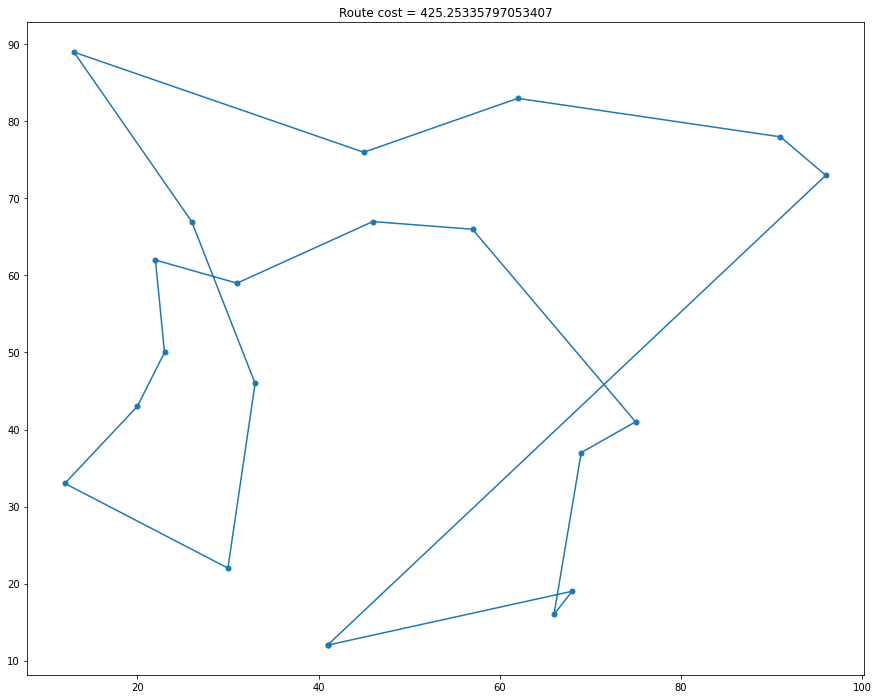

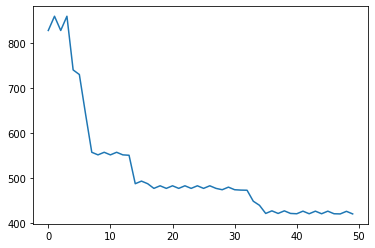

In [17]:
new_route, history_sa = simulated_anealing(rt, niter=50, temp=150.0)
new_route.show()
plt.plot(history_sa)
plt.show()

In [11]:
def tournament_selection(population, elite_size=20):
    population_cost = np.array([r.cost() for r in population])
    population_idx = np.argsort(population_cost)
    return population[population_idx][:elite_size]

def mutate_population(population, mutation_rate=0.01):
    for p in population:
        p.mutate(mutation_rate)
    return population

def next_generation(population, elite_size=20, mutation_rate=0.01):
    population_cost = np.array([r.cost() for r in population])
    population_idx = np.argsort(population_cost)

    selectionResults = tournament_selection(population, elite_size)
    #matingpool = matingPool(currentGen, selectionResults)
    #children = breedPopulation(matingpool, eliteSize)
    population = mutate_population(population, mutation_rate)
    return population

def genetic_optimization(cities, pop_size=100, elite_size=20, mutation_rate=0.01, niter=10):
    if niter <= 0: return route(cities)

    # Create population
    population = np.array([route(cities) for i in range(pop_size)])
    for i in range(niter):
        population = next_generation(population, elite_size, mutation_rate)

    #print([pop.cost() for pop in population])
    return population[0]

In [12]:
new_route = genetic_optimization(ct)
new_route.show()

TypeError: ignored

Create a fitness function

In [ ]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

Create mating pool

In [ ]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

Create a crossover function for two parents to create one child

In [ ]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

Create function to run crossover over full mating pool

In [ ]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

Create function to mutate a single route

In [ ]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

Create function to run mutation over entire population

In [ ]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

Put all steps together to create the next generation

In [ ]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

Final step: create the genetic algorithm

In [ ]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

## Running the genetic algorithm

Create list of cities

In [ ]:
cityList = []

for i in range(0,25):
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))

Run the genetic algorithm

In [ ]:
geneticAlgorithm(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)

## Plot the progress

Note, this will win run a separate GA

In [ ]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

Run the function with our assumptions to see how distance has improved in each generation

In [ ]:
geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)